# **Cluster Return Prediction with VAR and Evaluation**

In [44]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
from scipy import sparse
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
import seaborn as sns

# Setup paths (adjust if your notebook is in a different location relative to Main_modules)
try:
    module_path = os.path.abspath(os.path.join(os.getcwd(), '../Main_modules'))
    if module_path not in sys.path:
        sys.path.append(module_path)
except Exception as e:
    print(f"Error setting up module path: {e}")

warnings.filterwarnings("ignore")

try:
    from signet.cluster import Cluster
except ImportError:
    print("Signet package not found. Attempting to install from GitHub...")
    try:
        import subprocess
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "git+https://github.com/alan-turing-institute/SigNet.git"]
        )
        from signet.cluster import Cluster
        print("Signet package installed successfully.")
    except Exception as e:
        print(f"Error installing Signet package: {e}")
        print("Please install it manually: pip install git+https://github.com/alan-turing-institute/SigNet.git")

class ClusterVARForecaster:
    def __init__(self, n_clusters, cluster_method, var_order, sigma_for_weights=0.01):

        self.n_clusters = max(1, int(n_clusters))
        self.cluster_method = cluster_method
        self.var_order = max(1, int(var_order))
        self.sigma_for_weights = sigma_for_weights
        self.corr_matrix_ = None
        self.cluster_definitions_ = None
        self.lookback_start_idx_ = None
        self.lookback_end_idx_ = None

    def _calculate_correlation_matrix(self, asset_returns_lookback_df):
        if asset_returns_lookback_df.empty or asset_returns_lookback_df.shape[1] < 2:
            return pd.DataFrame(index=asset_returns_lookback_df.columns, columns=asset_returns_lookback_df.columns).fillna(0)
        # Normalize data before correlation to handle different scales
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(asset_returns_lookback_df)
        normalized_df = pd.DataFrame(normalized_data, index=asset_returns_lookback_df.index, columns=asset_returns_lookback_df.columns)
        return normalized_df.corr(method='pearson').fillna(0)

    def _apply_clustering_algorithm(self, correlation_matrix_df, num_clusters_to_form):
        def _get_signet_data(corr_df):
            pos_corr = corr_df.applymap(lambda x: x if x >= 0 else 0)
            neg_corr = corr_df.applymap(lambda x: abs(x) if x < 0 else 0)
            return (sparse.csc_matrix(pos_corr.values), sparse.csc_matrix(neg_corr.values))

        if correlation_matrix_df.empty:
            return np.array([])
        num_assets = correlation_matrix_df.shape[0]
        effective_n_clusters = min(num_clusters_to_form, num_assets) if num_assets > 0 else 1
        if effective_n_clusters <= 0 or num_assets == 0 : return np.array([])
        if effective_n_clusters == 1 and num_assets > 0: return np.zeros(num_assets, dtype=int)

        if self.cluster_method == 'Kmeans':
             # KMeans typically works better on the data directly or features, rather than correlation of correlations
            data_for_kmeans = correlation_matrix_df.fillna(0) # Using correlation matrix as features
            if data_for_kmeans.shape[0] < effective_n_clusters: # Not enough samples for n_clusters
                effective_n_clusters = data_for_kmeans.shape[0]
            if effective_n_clusters == 0: return np.zeros(num_assets, dtype=int)
            kmeans = KMeans(n_clusters=effective_n_clusters, random_state=0, n_init='auto')
            labels = kmeans.fit_predict(data_for_kmeans)
        elif self.cluster_method in ['SPONGE', 'signed_laplacian', 'SPONGE_sym']:
            signet_data = _get_signet_data(correlation_matrix_df)
            cluster_obj = Cluster(signet_data)
            if self.cluster_method == 'SPONGE': labels = cluster_obj.SPONGE(effective_n_clusters)
            elif self.cluster_method == 'signed_laplacian': labels = cluster_obj.spectral_cluster_laplacian(effective_n_clusters)
            else: labels = cluster_obj.SPONGE_sym(effective_n_clusters)
        elif self.cluster_method == 'spectral_clustering':
            affinity_matrix = np.abs(correlation_matrix_df.fillna(0).values)
            affinity_matrix = (affinity_matrix + affinity_matrix.T) / 2
            np.fill_diagonal(affinity_matrix, 1)
            if affinity_matrix.shape[0] < effective_n_clusters:
                effective_n_clusters = affinity_matrix.shape[0]
            if effective_n_clusters == 0: return np.zeros(num_assets, dtype=int)
            try:
                sc = SpectralClustering(n_clusters=effective_n_clusters, affinity='precomputed', random_state=0, assign_labels='kmeans')
                labels = sc.fit_predict(affinity_matrix)
            except Exception: # Fallback to KMeans if SpectralClustering fails
                data_for_kmeans = correlation_matrix_df.fillna(0)
                if data_for_kmeans.shape[0] < effective_n_clusters: effective_n_clusters = data_for_kmeans.shape[0]
                if effective_n_clusters == 0: return np.zeros(num_assets, dtype=int)
                kmeans = KMeans(n_clusters=effective_n_clusters, random_state=0, n_init='auto')
                labels = kmeans.fit_predict(data_for_kmeans)
        else:
            raise ValueError(f"Unknown clustering method: {self.cluster_method}")

        if not isinstance(labels, np.ndarray) or labels.size == 0:
            if num_assets > 0: return np.zeros(num_assets, dtype=int)
            return np.array([])
        return labels

    def _define_clusters_and_centroids(self, asset_returns_lookback_df):
        self.corr_matrix_ = self._calculate_correlation_matrix(asset_returns_lookback_df)
        num_assets = self.corr_matrix_.shape[0]
        if num_assets == 0:
            self.cluster_definitions_ = {}
            return

        labels = self._apply_clustering_algorithm(self.corr_matrix_, self.n_clusters)
        if labels.size == 0 and num_assets > 0: labels = np.zeros(num_assets, dtype=int)
        elif labels.size == 0 and num_assets == 0:
            self.cluster_definitions_ = {}; return

        asset_names = list(self.corr_matrix_.columns)
        labeled_assets = pd.DataFrame({'ClusterLabel': labels}, index=asset_names)
        actual_n_clusters = len(np.unique(labels))
        self.n_clusters = actual_n_clusters

        cluster_definitions = {}
        for label_val in np.unique(labels):
            cluster_name = f'Cluster_{label_val + 1}'
            tickers_in_cluster = list(labeled_assets[labeled_assets['ClusterLabel'] == label_val].index)
            if not tickers_in_cluster: continue
            valid_tickers_for_centroid = [t for t in tickers_in_cluster if t in asset_returns_lookback_df.columns]
            if not valid_tickers_for_centroid:
                centroid_ts = pd.Series(np.zeros(len(asset_returns_lookback_df)), index=asset_returns_lookback_df.index)
            else:
                centroid_ts = asset_returns_lookback_df[valid_tickers_for_centroid].mean(axis=1)
            cluster_definitions[cluster_name] = {'tickers': tickers_in_cluster, 'centroid_ts': centroid_ts}
        self.cluster_definitions_ = cluster_definitions

    def _calculate_weighted_cluster_returns(self, asset_returns_df, period_indices):
        if not self.cluster_definitions_:
            return pd.DataFrame()
        start_idx, end_idx = period_indices
        if not (0 <= start_idx < end_idx <= len(asset_returns_df)):
            return pd.DataFrame(index=pd.Index([]), columns=list(self.cluster_definitions_.keys()))

        data_slice_current_period = asset_returns_df.iloc[start_idx:end_idx]
        cluster_returns_dict = {}
        for cluster_name, info in self.cluster_definitions_.items():
            tickers_in_cluster = info['tickers']
            centroid_lookback_ts = info['centroid_ts']
            asset_gaussian_weights = {}
            total_gaussian_weight_sum = 0.0
            for ticker in tickers_in_cluster:
                if ticker in asset_returns_df.columns:
                    asset_returns_during_lookback = asset_returns_df[ticker].iloc[self.lookback_start_idx_:self.lookback_end_idx_]
                    if len(asset_returns_during_lookback) == len(centroid_lookback_ts):
                        squared_distance = np.sum((centroid_lookback_ts.values - asset_returns_during_lookback.values)**2)
                        weight = np.exp(-squared_distance / (2 * (self.sigma_for_weights**2)))
                        asset_gaussian_weights[ticker] = weight
                        total_gaussian_weight_sum += weight
                    else: asset_gaussian_weights[ticker] = 0.0
                else: asset_gaussian_weights[ticker] = 0.0

            current_cluster_period_returns = pd.Series(0.0, index=data_slice_current_period.index)
            if total_gaussian_weight_sum > 1e-9:
                for ticker, unnormalized_weight in asset_gaussian_weights.items():
                    if ticker in data_slice_current_period.columns:
                        normalized_weight = unnormalized_weight / total_gaussian_weight_sum
                        current_cluster_period_returns += data_slice_current_period[ticker] * normalized_weight
            elif tickers_in_cluster:
                valid_tickers_in_current_slice = [t for t in tickers_in_cluster if t in data_slice_current_period.columns]
                if valid_tickers_in_current_slice:
                    equal_weight = 1.0 / len(valid_tickers_in_current_slice)
                    for ticker_in_slice in valid_tickers_in_current_slice:
                        current_cluster_period_returns += data_slice_current_period[ticker_in_slice] * equal_weight
            cluster_returns_dict[cluster_name] = current_cluster_period_returns.values
        if not cluster_returns_dict:
            return pd.DataFrame(index=data_slice_current_period.index)
        return pd.DataFrame(cluster_returns_dict, index=data_slice_current_period.index)

    def _fit_var_and_forecast(self, lookback_cluster_returns_df, forecast_horizon):
        data_for_var = lookback_cluster_returns_df.astype(float).dropna(axis=1, how='all')
        if data_for_var.empty or data_for_var.shape[1] == 0:
            return pd.DataFrame(columns=lookback_cluster_returns_df.columns if not lookback_cluster_returns_df.empty else ["dummy_var_col"])
        num_obs, num_series = data_for_var.shape
        if num_series == 0: return pd.DataFrame(columns=data_for_var.columns)
        max_permissible_lags = (num_obs - 1) // num_series if num_series > 0 else 0
        effective_var_order = max(1, min(self.var_order, max_permissible_lags))
        if num_obs <= num_series * effective_var_order:
            return pd.DataFrame(columns=data_for_var.columns)
        try:
            model = VAR(data_for_var)
            results = model.fit(effective_var_order)
            lag_order_used = results.k_ar
            forecast_input = data_for_var.values[-lag_order_used:]
            forecast_array = results.forecast(y=forecast_input, steps=forecast_horizon)
        except Exception as e:
            return pd.DataFrame(columns=data_for_var.columns)
        forecast_index = pd.RangeIndex(start=0, stop=forecast_horizon, step=1)
        if not data_for_var.empty and hasattr(data_for_var.index, 'freq') and data_for_var.index.freq is not None:
            try:
                forecast_index = pd.date_range(start=data_for_var.index[-1] + data_for_var.index.freq, periods=forecast_horizon, freq=data_for_var.index.freq)
            except Exception: pass
        forecast_df = pd.DataFrame(forecast_array, columns=data_for_var.columns, index=forecast_index)
        return forecast_df.reindex(columns=lookback_cluster_returns_df.columns, fill_value=0.0)

    def process_step(self, asset_returns_df, lookback_indices, eval_len):
        self.lookback_start_idx_, self.lookback_end_idx_ = lookback_indices
        lookback_asset_returns = asset_returns_df.iloc[self.lookback_start_idx_:self.lookback_end_idx_]
        self._define_clusters_and_centroids(lookback_asset_returns)
        if not self.cluster_definitions_:
            return pd.DataFrame(), pd.DataFrame()
        lookback_cluster_returns = self._calculate_weighted_cluster_returns(asset_returns_df, lookback_indices)
        if lookback_cluster_returns.empty or lookback_cluster_returns.isnull().all().all():
            cols = list(self.cluster_definitions_.keys()) if self.cluster_definitions_ else []
            return pd.DataFrame(columns=cols), pd.DataFrame(columns=cols)
        forecasted_returns = self._fit_var_and_forecast(lookback_cluster_returns, eval_len)
        eval_start_idx, eval_end_idx = self.lookback_end_idx_, min(self.lookback_end_idx_ + eval_len, len(asset_returns_df))
        if eval_start_idx >= eval_end_idx:
            cols = forecasted_returns.columns if not forecasted_returns.empty else (list(self.cluster_definitions_.keys()) if self.cluster_definitions_ else [])
            return forecasted_returns.head(0), pd.DataFrame(columns=cols)
        true_eval_returns = self._calculate_weighted_cluster_returns(asset_returns_df, (eval_start_idx, eval_end_idx))
        if not forecasted_returns.empty and not true_eval_returns.empty:
            if len(forecasted_returns) == len(true_eval_returns): forecasted_returns.index = true_eval_returns.index
            elif len(forecasted_returns) > len(true_eval_returns): forecasted_returns = forecasted_returns.iloc[:len(true_eval_returns)]; forecasted_returns.index = true_eval_returns.index
            common_cols = forecasted_returns.columns.intersection(true_eval_returns.columns)
            forecasted_returns = forecasted_returns[common_cols]
            true_eval_returns = true_eval_returns[common_cols]
        elif forecasted_returns.empty and not true_eval_returns.empty: forecasted_returns = pd.DataFrame(index=true_eval_returns.index, columns=true_eval_returns.columns).fillna(0)
        elif not forecasted_returns.empty and true_eval_returns.empty: true_eval_returns = pd.DataFrame(index=forecasted_returns.index, columns=forecasted_returns.columns).fillna(0)
        return forecasted_returns, true_eval_returns

class NaiveVARForecaster:
    def __init__(self, var_order):
        self.var_order = max(1, int(var_order))
        self.asset_names_ = None

    def _fit_var_and_forecast(self, lookback_asset_returns_df, forecast_horizon):
        data_for_var = lookback_asset_returns_df.astype(float).dropna(axis=1, how='all')
        current_cols = self.asset_names_ if self.asset_names_ else (data_for_var.columns.tolist() if not data_for_var.empty else (lookback_asset_returns_df.columns.tolist() if not lookback_asset_returns_df.empty else ["dummy_var_col"]))
        if data_for_var.empty or data_for_var.shape[1] == 0: return pd.DataFrame(columns=current_cols)
        # num_obs, num_series = data_for_var.shape
        # print(num_obs, num_series)
        # if num_series == 0: return pd.DataFrame(columns=current_cols)
        # max_permissible_lags = (num_obs - 1) // num_series if num_series > 0 else 0
        # print(max_permissible_lags)
        effective_var_order = self.var_order #max(1, min(self.var_order, max_permissible_lags))
        print(effective_var_order)
        # if num_obs <= num_series * effective_var_order: return pd.DataFrame(columns=current_cols)
        try:
            model = VAR(data_for_var)
            results = model.fit(effective_var_order)
            lag_order_used = results.k_ar
            forecast_input = data_for_var.values[-lag_order_used:]
            forecast_array = results.forecast(y=forecast_input, steps=forecast_horizon)
        except Exception as e:
            return pd.DataFrame(columns=current_cols)
        forecast_index = pd.RangeIndex(start=0, stop=forecast_horizon, step=1)
        if not data_for_var.empty and hasattr(data_for_var.index, 'freq') and data_for_var.index.freq is not None:
            try: forecast_index = pd.date_range(start=data_for_var.index[-1] + data_for_var.index.freq, periods=forecast_horizon, freq=data_for_var.index.freq)
            except Exception: pass
        forecast_df = pd.DataFrame(forecast_array, columns=data_for_var.columns, index=forecast_index)
        return forecast_df.reindex(columns=self.asset_names_ if self.asset_names_ else current_cols, fill_value=0.0)

    def process_step(self, asset_returns_df, lookback_indices, eval_len):
        lookback_start_idx, lookback_end_idx = lookback_indices
        lookback_asset_returns = asset_returns_df.iloc[lookback_start_idx:lookback_end_idx]
        self.asset_names_ = lookback_asset_returns.columns.tolist()
        if lookback_asset_returns.empty or lookback_asset_returns.isnull().all().all(): return pd.DataFrame(columns=self.asset_names_), pd.DataFrame(columns=self.asset_names_)
        forecasted_returns = self._fit_var_and_forecast(lookback_asset_returns, eval_len)
        eval_start_idx, eval_end_idx = lookback_end_idx, min(lookback_end_idx + eval_len, len(asset_returns_df))
        if eval_start_idx >= eval_end_idx:
            true_eval_asset_returns = pd.DataFrame(columns=self.asset_names_)
            if forecasted_returns.empty: forecasted_returns = pd.DataFrame(columns=self.asset_names_)
            return forecasted_returns.head(0), true_eval_asset_returns
        true_eval_asset_returns = asset_returns_df.iloc[eval_start_idx:eval_end_idx].reindex(columns=self.asset_names_, fill_value=0.0)
        if not forecasted_returns.empty and not true_eval_asset_returns.empty:
            if len(forecasted_returns) == len(true_eval_asset_returns): forecasted_returns.index = true_eval_asset_returns.index
            elif len(forecasted_returns) > len(true_eval_asset_returns): forecasted_returns = forecasted_returns.iloc[:len(true_eval_asset_returns)]; forecasted_returns.index = true_eval_asset_returns.index
        if forecasted_returns.empty: forecasted_returns = pd.DataFrame(0.0, index=true_eval_asset_returns.index if not true_eval_asset_returns.empty else pd.RangeIndex(eval_len if eval_start_idx < eval_end_idx else 0), columns=self.asset_names_)
        else: forecasted_returns = forecasted_returns.reindex(columns=self.asset_names_, fill_value=0.0)
        if true_eval_asset_returns.empty: true_eval_asset_returns = pd.DataFrame(0.0, index=forecasted_returns.index if not forecasted_returns.empty else pd.RangeIndex(eval_len if eval_start_idx < eval_end_idx else 0), columns=self.asset_names_)
        else: true_eval_asset_returns = true_eval_asset_returns.reindex(columns=self.asset_names_, fill_value=0.0)
        if not forecasted_returns.empty and not true_eval_asset_returns.empty:
            common_cols = forecasted_returns.columns.intersection(true_eval_asset_returns.columns)
            forecasted_returns = forecasted_returns[common_cols]
            true_eval_asset_returns = true_eval_asset_returns[common_cols]
        return forecasted_returns, true_eval_asset_returns

def calculate_forecast_errors(forecast_df, actual_df, metric='mse'):
    if forecast_df.empty or actual_df.empty: return pd.Series(dtype=float)
    common_cols = forecast_df.columns.intersection(actual_df.columns)
    if common_cols.empty: return pd.Series(dtype=float)
    f_aligned, a_aligned = forecast_df[common_cols].copy(), actual_df[common_cols].copy()
    min_len = min(len(f_aligned), len(a_aligned))
    if min_len == 0: return pd.Series(dtype=float)
    f_aligned, a_aligned = f_aligned.iloc[:min_len], a_aligned.iloc[:min_len]
    if not f_aligned.index.equals(a_aligned.index):
        f_aligned.reset_index(drop=True, inplace=True); a_aligned.reset_index(drop=True, inplace=True)
    errors = f_aligned - a_aligned
    if metric.lower() == 'mse': scores = (errors ** 2).mean()
    elif metric.lower() == 'mae': scores = errors.abs().mean()
    elif metric.lower() == 'rmse': scores = np.sqrt((errors ** 2).mean())
    else: raise ValueError(f"Unknown error metric: {metric}")
    return scores

def run_sliding_window_var_evaluation(
    asset_returns_df, initial_lookback_len, eval_len, n_clusters,
    cluster_method, var_order, sigma_intra_cluster, num_windows, error_metric='mse',
    store_sample_forecasts=True, run_naive_var_comparison=True
):
    all_window_errors_cluster_raw = [] # Store raw Series for cluster errors
    all_window_errors_naive_list = []
    sample_forecast_data_cluster, sample_actual_data_cluster, sample_window_idx_cluster = None, None, None
    cluster_forecaster = ClusterVARForecaster(n_clusters, cluster_method, var_order, sigma_intra_cluster)
    if run_naive_var_comparison: naive_forecaster = NaiveVARForecaster(var_order)

    for i in range(num_windows):
        lb_start, lb_end = i * eval_len, i * eval_len + initial_lookback_len
        if lb_end > len(asset_returns_df): print(f"Window {i+1}: Lookback period extends beyond data. Stopping."); break
        eval_start_idx = lb_end
        if eval_start_idx >= len(asset_returns_df): print(f"Window {i+1}: Evaluation starts at or after data end. Stopping."); break
        current_eval_len = min(eval_len, len(asset_returns_df) - eval_start_idx)
        if current_eval_len <= 0: print(f"Window {i+1}: No data for evaluation. Stopping."); break
        # print(f"Processing window {i+1}/{num_windows} (VAR Order: {var_order})...") # Modified for grid search context
        forecast_df_cluster, actual_df_cluster = cluster_forecaster.process_step(asset_returns_df, (lb_start, lb_end), current_eval_len)
        if not forecast_df_cluster.empty and not actual_df_cluster.empty:
            window_errors_cluster = calculate_forecast_errors(forecast_df_cluster, actual_df_cluster, error_metric)
            if not window_errors_cluster.empty:
                all_window_errors_cluster_raw.append(window_errors_cluster) # Store the Series of errors for this window
                if store_sample_forecasts and sample_forecast_data_cluster is None:
                    sample_forecast_data_cluster, sample_actual_data_cluster, sample_window_idx_cluster = forecast_df_cluster.copy(), actual_df_cluster.copy(), i
        if run_naive_var_comparison:
            forecast_df_naive, actual_df_naive = naive_forecaster.process_step(asset_returns_df, (lb_start, lb_end), current_eval_len)
            if not forecast_df_naive.empty and not actual_df_naive.empty:
                window_errors_naive_per_asset = calculate_forecast_errors(forecast_df_naive, actual_df_naive, error_metric)
                if not window_errors_naive_per_asset.empty: all_window_errors_naive_list.append({'Window_ID': i, 'Avg_Window_Error': window_errors_naive_per_asset.mean(), 'VAR_Order': var_order, 'Method': 'Naive VAR'})

    # Process cluster errors: calculate average per window and tag with VAR_Order and Method
    processed_cluster_errors_list = []
    for window_idx, error_series in enumerate(all_window_errors_cluster_raw):
        avg_cluster_error_for_window = error_series.mean()
        processed_cluster_errors_list.append({'Window_ID': window_idx, 'Avg_Window_Error': avg_cluster_error_for_window, 'VAR_Order': var_order, 'Method': 'Clustered VAR'})

    results_dict = {
        'cluster_avg_errors_list': processed_cluster_errors_list, # List of dicts with window-averaged cluster errors
        'sample_forecast_cluster': sample_forecast_data_cluster,
        'sample_actual_cluster': sample_actual_data_cluster,
        'sample_window_idx_cluster': sample_window_idx_cluster
    }
    if run_naive_var_comparison: results_dict['naive_avg_errors_list'] = all_window_errors_naive_list
    return results_dict

def perform_elbow_analysis(asset_returns_df, max_clusters, cluster_method='Kmeans', lookback_len=252):
    """Performs elbow analysis for KMeans clustering on correlation matrix features."""
    if asset_returns_df.empty or len(asset_returns_df) < lookback_len:
        print("Not enough data for elbow analysis.")
        return None, None

    lookback_data = asset_returns_df.iloc[:lookback_len]
    if lookback_data.shape[1] < 2:
        print("Not enough assets for correlation matrix in elbow analysis.")
        return None, None

    temp_forecaster = ClusterVARForecaster(n_clusters=1, cluster_method='Kmeans', var_order=1) # method doesn't matter here
    corr_matrix = temp_forecaster._calculate_correlation_matrix(lookback_data)

    if corr_matrix.empty:
        print("Correlation matrix is empty for elbow analysis.")
        return None, None

    data_for_kmeans = corr_matrix.fillna(0).values
    if data_for_kmeans.shape[0] < 2:
        print(f"Not enough assets ({data_for_kmeans.shape[0]}) in correlation matrix for KMeans elbow analysis.")
        return None, None

    inertia_values = []
    # Number of clusters cannot exceed number of samples (assets, in this case)
    # Also, k_range must start from 1 if possible, or 2 if only 1 sample.
    # For Kmeans, n_clusters must be >= 1. If data_for_kmeans.shape[0] is 1, then Kmeans(1) is the only option.
    upper_k_bound = min(max_clusters + 1, data_for_kmeans.shape[0] + (1 if data_for_kmeans.shape[0] > 0 else 0) )
    if upper_k_bound <=1: # Handle cases with 0 or 1 asset for clustering
        k_range = range(1,upper_k_bound) if upper_k_bound > 1 else ([1] if data_for_kmeans.shape[0] >=1 else [])
    else:
        k_range = range(1, upper_k_bound)

    if not list(k_range):
        print("Cannot perform elbow analysis: k_range is empty (not enough assets for clustering range).")
        return None, None

    print(f"Performing elbow analysis for K-Means with up to {max(k_range) if list(k_range) else 0} clusters...")
    for k_val in k_range:
        # Ensure k_val is not greater than number of samples
        current_k = min(k_val, data_for_kmeans.shape[0])
        if current_k < 1: continue # Should not happen with k_range logic but defensive
        kmeans = KMeans(n_clusters=current_k, random_state=0, n_init='auto')
        kmeans.fit(data_for_kmeans)
        inertia_values.append(kmeans.inertia_)

    if not inertia_values:
        print("No inertia values calculated. Elbow plot cannot be generated.")
        return None, None

    plt.figure(figsize=(10, 6))
    plt.plot(list(k_range)[:len(inertia_values)], inertia_values, marker='o') # Ensure k_range matches length of inertia_values
    plt.title('Elbow Plot for Optimal Number of Clusters (KMeans on Correlation Matrix)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (WCSS)')
    if list(k_range):
      plt.xticks(list(k_range)[:len(inertia_values)])
    plt.grid(True)
    plt.show()
    return k_range, inertia_values

## 1. Load and Clean Data

In [45]:
file_path = r'C:\Users\james\ICAIF_25\Data\OPCL_20000103_20201231.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"File not found at {file_path}. Creating dummy data.")
    dummy_dates = pd.date_range(start='2000-01-03', periods=5295, freq='B')
    dummy_tickers = [f'TICK{i:03d}' for i in range(1, 301)]
    data = np.random.rand(len(dummy_tickers), len(dummy_dates)) * 0.2 - 0.1 # Simulate daily returns ~ N(0, var)
    df = pd.DataFrame(data, index=dummy_tickers, columns=[f'X{d.strftime("%Y%m%d")}' for d in dummy_dates])
    df = df.reset_index().rename(columns={'index': 'ticker'})

if not df.empty:
    df.set_index('ticker', inplace=True)
    df.columns = pd.to_datetime(df.columns.str.lstrip('X'), format='%Y%m%d').strftime('%Y-%m-%d')
    df_cleaned = df.dropna().transpose()
    df_cleaned.index = pd.to_datetime(df_cleaned.index)
    # Assuming the data is already returns. If it were prices, you would calculate returns:
    # df_cleaned = df_cleaned.pct_change().fillna(0)
    print("Data loaded and cleaned. Sample (first 5 rows/cols):")
    print(df_cleaned.iloc[0:5,0:5])
else:
    print("DataFrame is empty, cannot proceed.")
    df_cleaned = pd.DataFrame()

Data loaded and cleaned. Sample (first 5 rows/cols):
ticker            AA       ABM       ABT       ADI       ADM
2000-01-03 -0.013042 -0.009188 -0.007117 -0.036071  0.000000
2000-01-04  0.010043  0.012346 -0.012786 -0.044261  0.005277
2000-01-05  0.047628 -0.006192  0.011111  0.014493 -0.015915
2000-01-06 -0.011713  0.000000  0.032553 -0.027719  0.010695
2000-01-07 -0.016118  0.003091  0.028573  0.033654  0.005249


In [46]:
if not df_cleaned.empty:
    print(f"Shape of the cleaned data: {df_cleaned.shape}")
else:
    print("df_cleaned is empty.")

Shape of the cleaned data: (5279, 663)


## 2. VAR Lag Grid Search and Evaluation

In [ ]:
##################################################################### PARAMETERS #####################################################################
initial_lookback_len = 252
evaluation_len = 21
num_clusters_config = 7 # Update based on elbow plot or domain knowledge
cluster_method_config = 'SPONGE_sym'
sigma_config = 0.01
num_windows_config = 5  # Reduced for quicker grid search example
error_metric_config = 'rmse'
var_orders_to_test_config = range(1, 20, 2) # List of VAR orders for grid search
####################################################################################################################################################

all_lags_combined_errors = [] # Will store list of dicts for both methods
sample_forecast_details = {}

if 'df_cleaned' in locals() and not df_cleaned.empty:
    historical_data = df_cleaned

    for var_order_val in var_orders_to_test_config:
        print(f"\n===== Running Evaluation for VAR Order: {var_order_val} =====")
        results_dict = run_sliding_window_var_evaluation(
            asset_returns_df=historical_data,
            initial_lookback_len=initial_lookback_len,
            eval_len=evaluation_len,
            n_clusters=num_clusters_config,
            cluster_method=cluster_method_config,
            var_order=var_order_val,
            sigma_intra_cluster=sigma_config,
            num_windows=num_windows_config,
            error_metric=error_metric_config,
            store_sample_forecasts= (var_order_val == var_orders_to_test_config[-1]),
            run_naive_var_comparison=True
        )

        if results_dict.get('cluster_avg_errors_list'):
            all_lags_combined_errors.extend(results_dict['cluster_avg_errors_list'])

        if results_dict.get('naive_avg_errors_list'):
            all_lags_combined_errors.extend(results_dict['naive_avg_errors_list'])

        if var_order_val == var_orders_to_test_config[-1]:
            sample_forecast_details['forecast'] = results_dict.get('sample_forecast_cluster')
            sample_forecast_details['actual'] = results_dict.get('sample_actual_cluster')
            sample_forecast_details['window_idx'] = results_dict.get('sample_window_idx_cluster')
            sample_forecast_details['var_order'] = var_order_val

    df_all_errors_by_lag_method = pd.DataFrame(all_lags_combined_errors)

    print("\n--- Grid Search Completed ---")
    if not df_all_errors_by_lag_method.empty:
        print("\nAverage Errors per Lag Order and Method:")
        print(df_all_errors_by_lag_method.groupby(['VAR_Order', 'Method'])['Avg_Window_Error'].mean().unstack())
else:
    print("Historical data (df_cleaned) is empty. Skipping VAR lag grid search and evaluation.")
    df_all_errors_by_lag_method = pd.DataFrame()


===== Running Evaluation for VAR Order: 1 =====
1
1
1
1
1

===== Running Evaluation for VAR Order: 3 =====
3
3
3
3
3

===== Running Evaluation for VAR Order: 5 =====
5
5
5
5
5

===== Running Evaluation for VAR Order: 7 =====
7


## 3. Visualization of Grid Search Results and Sample Forecast

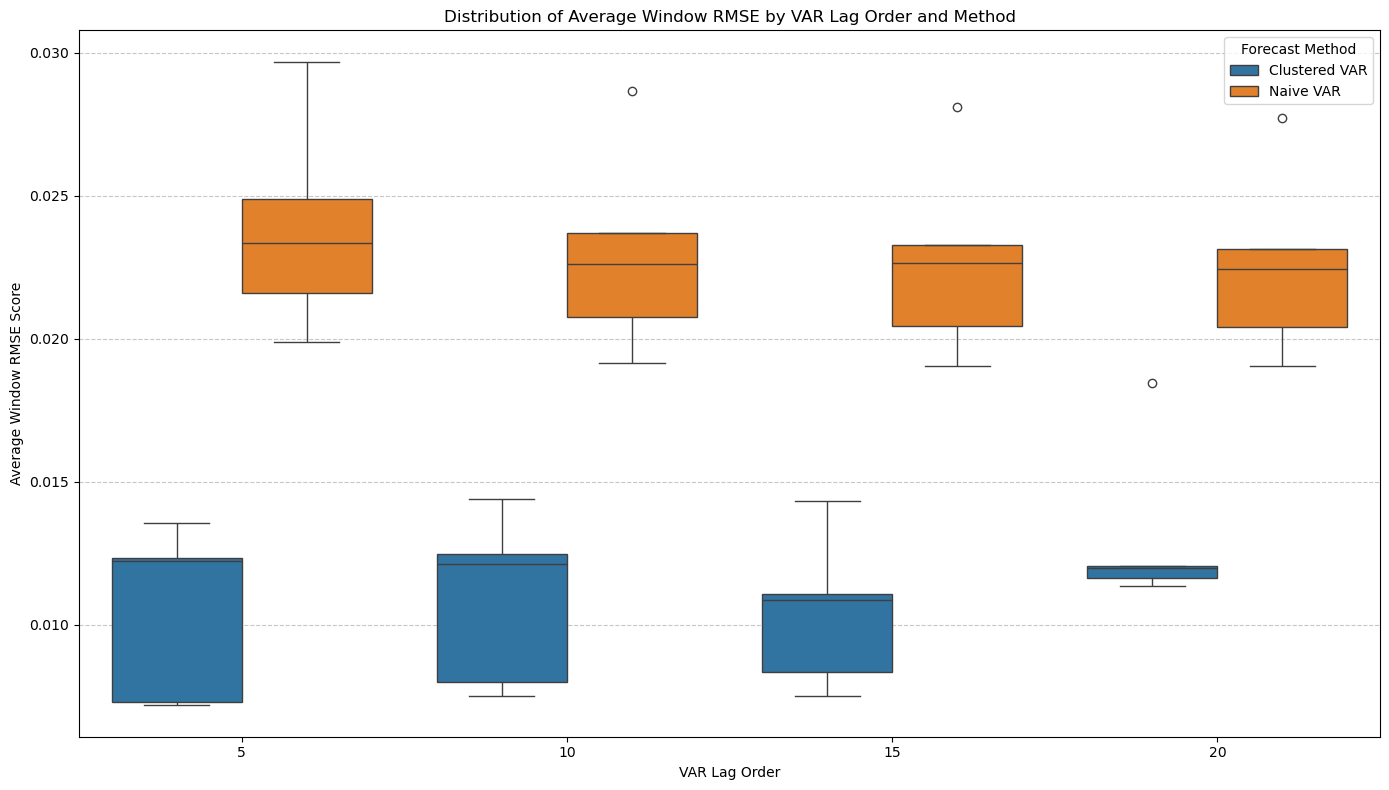


--- Plotting Predictions vs. Actuals for Sample Window 1 (Clustered VAR with Lag 20) ---


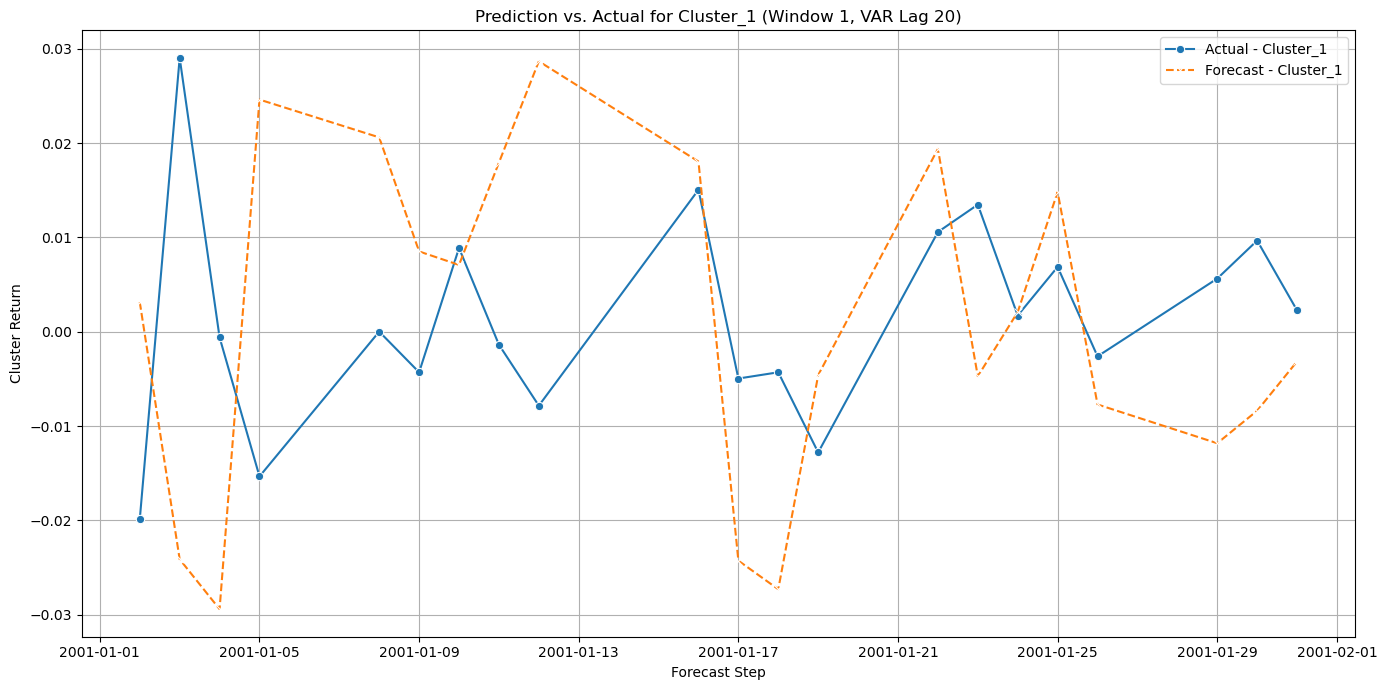

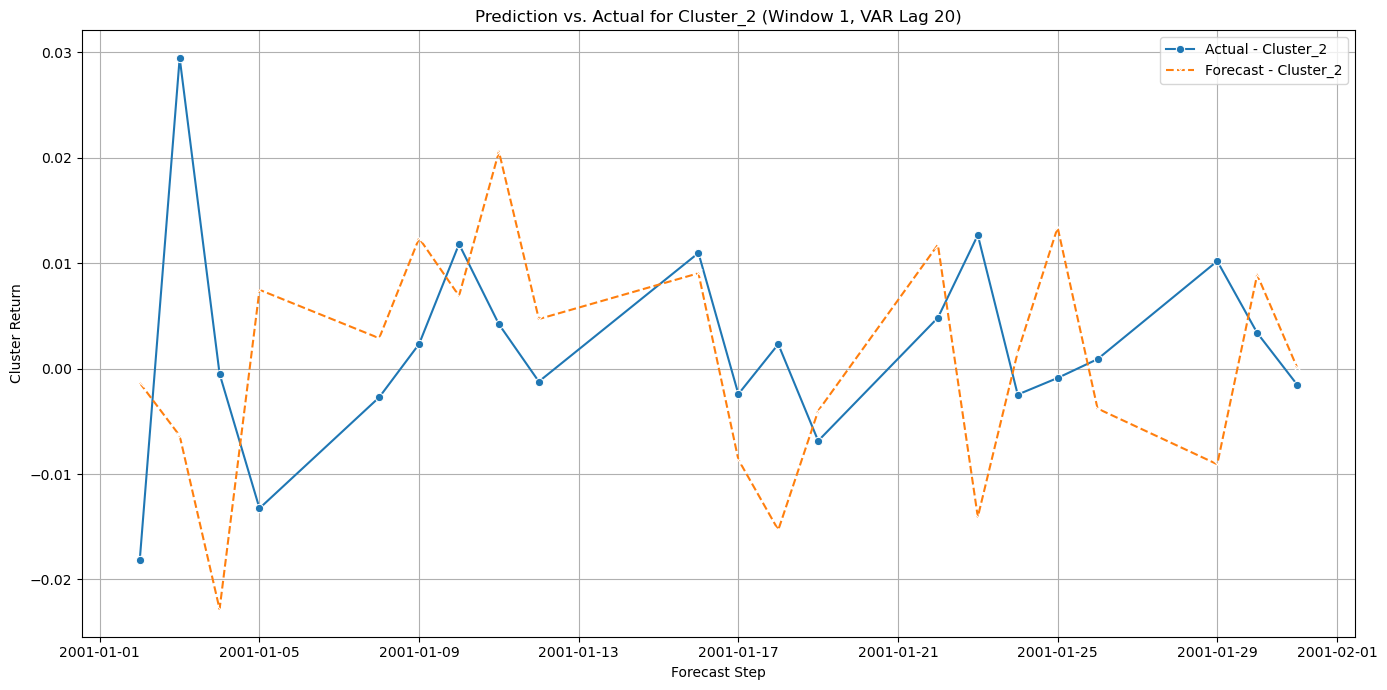

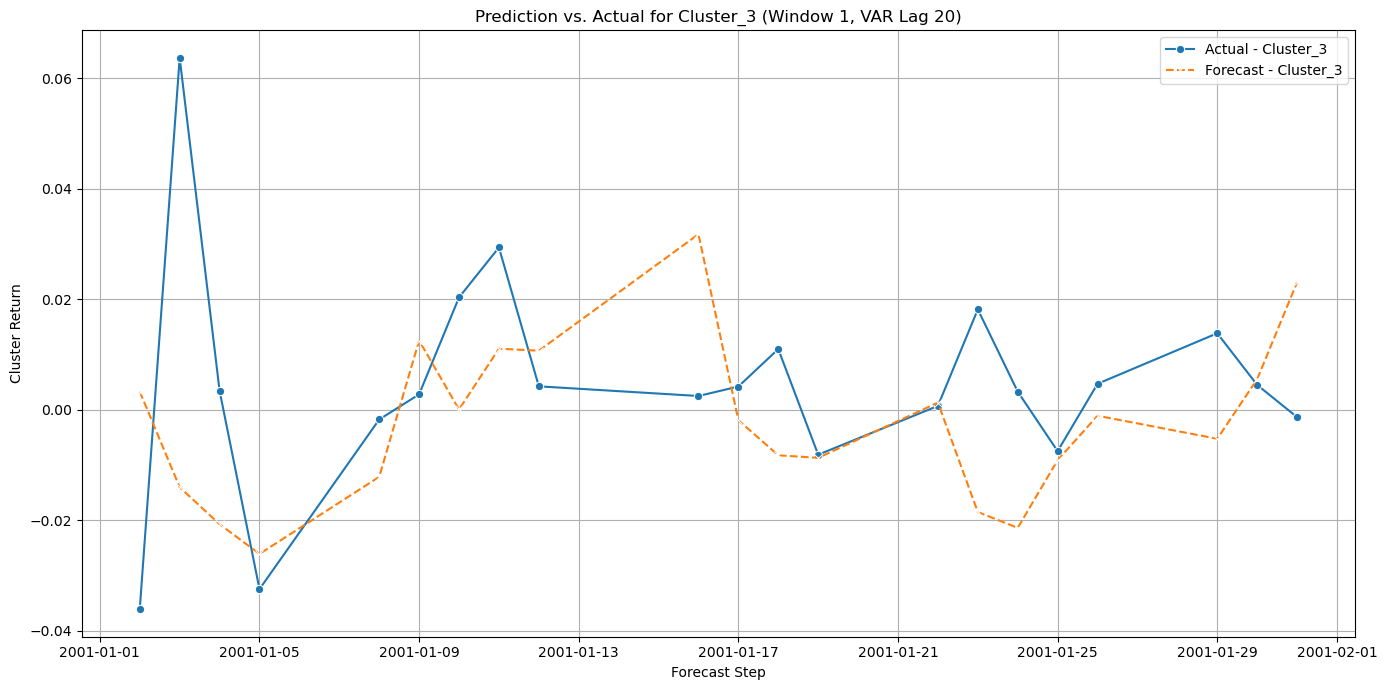

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Combined Boxplot for Clustered VAR and Naive VAR Errors by Lag Order ---
if 'df_all_errors_by_lag_method' in locals() and not df_all_errors_by_lag_method.empty and \
   'Avg_Window_Error' in df_all_errors_by_lag_method.columns and \
   'VAR_Order' in df_all_errors_by_lag_method.columns and \
   'Method' in df_all_errors_by_lag_method.columns:

    plt.figure(figsize=(14, 8))
    sns.boxplot(x='VAR_Order', y='Avg_Window_Error', hue='Method', data=df_all_errors_by_lag_method)
    plt.title(f'Distribution of Average Window {error_metric_config.upper()} by VAR Lag Order and Method')
    plt.xlabel('VAR Lag Order')
    plt.ylabel(f'Average Window {error_metric_config.upper()} Score')
    plt.legend(title='Forecast Method')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for combined lag error boxplot. Ensure 'df_all_errors_by_lag_method' is populated correctly with 'VAR_Order', 'Avg_Window_Error', and 'Method' columns.")

# --- Plotting Predictions vs. Actuals for the Sampled Window (from one VAR order, Clustered VAR) ---
if 'sample_forecast_details' in locals() and sample_forecast_details.get('forecast') is not None:
    sample_forecast = sample_forecast_details['forecast']
    sample_actual = sample_forecast_details['actual']
    stored_window_idx = sample_forecast_details['window_idx']
    stored_var_order = sample_forecast_details['var_order']

    print(f"\n--- Plotting Predictions vs. Actuals for Sample Window {stored_window_idx + 1} (Clustered VAR with Lag {stored_var_order}) ---")
    num_clusters_to_plot = min(3, sample_forecast.shape[1]) if not sample_forecast.empty else 0
    if num_clusters_to_plot == 0:
        print("No cluster data available in the sample to plot.")
    else:
        for i in range(num_clusters_to_plot):
            cluster_name = sample_forecast.columns[i]
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=sample_actual[cluster_name], label=f'Actual - {cluster_name}', marker='o', linestyle='-')
            sns.lineplot(data=sample_forecast[cluster_name], label=f'Forecast - {cluster_name}', marker='x', linestyle='--')
            plt.title(f'Prediction vs. Actual for {cluster_name} (Window {stored_window_idx + 1}, VAR Lag {stored_var_order})')
            plt.xlabel('Forecast Step')
            plt.ylabel('Cluster Return')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
else:
    print("\nNo sample forecast/actual data available to plot.")